<h2> Analysis of Bone Mineral Densities in MrOS B1 Data (EDA1.ipynb) </h2> 

The purpose of this workbook is take begin exploring the vast amount of data that we have.  Through various methods of exploration, we hope to find general trends, patterns, and correlations in the data that will help lead to us a reliable predictive model. 

#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Retreival of Data](#eda_retrieval)
#### 3. [Exploration of NA Values](#eda_na)
#### 4. [Merging of Data](#eda_merge)
#### 5. [Imputing Null Values](#eda_KNN)
#### 6. [Descriptive Statistics](#eda_describe)
#### 7. [Outlier Review](#eda_outlier)
#### 8. [Multicollinearity Review](#eda_VIF)
#### 9. [Principal Component Review](#eda_PCA)
#### 10. [Using Feature Selection](#eda_FS)
#### 11. [Results for Modeling](#eda_FR)

### <a name="eda_import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries.  In addition to loading already pre-installed libraries, we've also had to install seaborn for plotting. 

In [1]:
!pip install seaborn --upgrade

     |████████████████████████████████| 296kB 3.5MB/s eta 0:00:01
  Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0


In [2]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 23.0MB 3.5MB/s eta 0:00:01
     |████████████████████████████████| 307kB 18.5MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [3]:
##import libraries required for analysis

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
import warnings


In [4]:
warnings.filterwarnings('ignore')

In [5]:
sns.__version__

'0.12.2'

### <a name="eda_retrieval"></a>Retreival of Data
The data needs to be retrieved from the Postgres database and stored in a dataframe for us to begin analyzing.

As we've described, the dataset is very wide and in order to properly analyze, we need to reduce the number of features we're looking at. 
1. From the b1aug16_raw table, we're limiting the columns to values containing bone mineral densities using regular expressions.
2. From the FAFEB23.SAS7BDAT file, we're limiting the columns to "ID","FANOTMOF".

In [6]:
##Connect to Postgre
import psycopg2
import sqlalchemy
import getpass
import pandas as pd 

user = "jwj8c8"
host = "pgsql.dsa.lan"
database = "casestdysu23t03"
password = getpass.getpass()
connectionstring = "postgresql://" + user + ":" + password + "@" + host + "/" + database
engine = sqlalchemy.create_engine(connectionstring)
connection = None

try:
    connection = engine.connect()
except Exception as err:
    print("An error has occurred trying to connect: {}".format(err))

del password

········


In [7]:
def binary2StringLiteral(df):
    for column in df.columns:
        if df[column].dtype == "object":
            df[column] = df[column].str.decode('utf-8')

In [8]:
query = "SELECT * FROM public.b1aug16_raw"
b1aug16_df = pd.read_sql_query(query, con=connection)

In [9]:
fafeb23_df = pd.read_sas("/dsa/groups/casestudy2023su/team03/FAFEB23.SAS7BDAT")
fafeb23_df = fafeb23_df[["ID","FANOTMOF","FAFXN","FAFXNT"]]
fafeb23_df.FAFXN = fafeb23_df.FAFXN.apply(lambda x: 1 if x > 0 else 0) 
fafeb23_df.FAFXNT = fafeb23_df.FAFXNT.apply(lambda x: 1 if x > 0 else 0) 
binary2StringLiteral(fafeb23_df)

In [10]:
##BMD values end in D
##Operator code for Hip scan, Spine Scan, and Whole Body Scan end in COD these values will need to be removed
##We will use a Negative lookback assertion 
##This method retains the various IDs in the table
baselineBMD = b1aug16_df.filter(regex="(?<!(CO))D$",axis=1)
baselineBMD_final = b1aug16_df.filter(regex="(?<!(CO))D$",axis=1)
baselineBMD.head()

,B1TRD,B1ITD,B1FND,B1WDD,B1THD,B1HPID,ID,B1L1D,B1L2D,B1L3D,...,B1LAD,B1RAD,B1LRD,B1RRD,B1TSD,B1LSD,B1PED,B1LLD,B1RLD,B1WBID
0,0.816111,1.22431,0.867423,0.784696,1.046450,A04250007,BI0001,1.135320,1.17017,1.244590,...,0.931609,0.943192,0.743156,0.659102,0.928960,1.35857,1.15584,1.27166,1.29073,A04250008
1,0.879885,1.11591,0.740235,0.519868,0.977156,A05020006,BI0002,1.233880,1.26274,1.194060,...,0.886045,0.930573,0.775296,0.740078,1.188770,1.33318,1.32048,1.27454,1.31312,A05020007
2,0.690143,1.12294,0.691843,0.505692,0.938607,A05030006,BI0003,0.745454,0.88662,0.964876,...,0.841374,0.878078,1.143010,0.698110,0.950109,0.89908,1.09222,1.23404,1.28587,A05030007
3,0.854573,1.14140,0.878307,0.648614,1.017220,A0503000A,BI0004,1.169730,1.31559,1.261980,...,0.894172,0.905256,0.808074,0.740336,1.406840,1.34156,1.36052,1.44115,1.40465,A0503000B
4,0.894594,1.25773,0.919494,0.585505,1.104740,A05040005,BI0005,1.036480,1.22224,1.176640,...,0.966746,0.969560,0.803625,0.747750,1.053460,1.16267,1.21803,1.68334,1.45254,A05040006


### <a name="eda_na"></a>Exploration of NA Values
Here we're doing initial exploration of the NAs present within each feature and dropping them which results in a loss of 134 rows. 

In [11]:
baselineBMD.isna().sum()

B1TRD      1
B1ITD      1
B1FND      1
B1WDD      1
B1THD      1
B1HPID     0
ID         0
B1L1D     35
B1L2D     24
B1L3D     35
B1L4D     66
B1TLD     10
B1SPID     7
B1TBD     39
B1SBD     39
B1HDD     39
B1LAD     39
B1RAD     39
B1LRD     39
B1RRD     39
B1TSD     39
B1LSD     39
B1PED     39
B1LLD     39
B1RLD     39
B1WBID    38
dtype: int64

In [12]:
baselineBMD.isna().sum()/baselineBMD.shape[0]

B1TRD     0.000167
B1ITD     0.000167
B1FND     0.000167
B1WDD     0.000167
B1THD     0.000167
B1HPID    0.000000
ID        0.000000
B1L1D     0.005839
B1L2D     0.004004
B1L3D     0.005839
B1L4D     0.011011
B1TLD     0.001668
B1SPID    0.001168
B1TBD     0.006507
B1SBD     0.006507
B1HDD     0.006507
B1LAD     0.006507
B1RAD     0.006507
B1LRD     0.006507
B1RRD     0.006507
B1TSD     0.006507
B1LSD     0.006507
B1PED     0.006507
B1LLD     0.006507
B1RLD     0.006507
B1WBID    0.006340
dtype: float64

In [13]:
baselineBMD.shape

(5994, 26)

In [14]:
bmd_with_nulls = baselineBMD.copy()


In [15]:
baselineBMD.dropna().shape

(5860, 26)

### <a name="eda_KNN"></a> Imputing Nulls
Some BMD variables are geniuinely missing. The missing BMD data contains an outsized proportion of fracture cases, leading us to believe these may not be randomly missing. Indeed the documentation says the missing values are due to imaging issues. Below we impute using k nearest neighbors. 

In [16]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

In [17]:
##remove the IDs
BMDcols = baselineBMD.filter(regex="(?<!I)D").columns

In [18]:
baselineBMD[BMDcols] = imputer.fit_transform(baselineBMD[BMDcols])

In [19]:
baselineBMD.head()

,B1TRD,B1ITD,B1FND,B1WDD,B1THD,B1HPID,ID,B1L1D,B1L2D,B1L3D,...,B1LAD,B1RAD,B1LRD,B1RRD,B1TSD,B1LSD,B1PED,B1LLD,B1RLD,B1WBID
0,0.816111,1.22431,0.867423,0.784696,1.046450,A04250007,BI0001,1.135320,1.17017,1.244590,...,0.931609,0.943192,0.743156,0.659102,0.928960,1.35857,1.15584,1.27166,1.29073,A04250008
1,0.879885,1.11591,0.740235,0.519868,0.977156,A05020006,BI0002,1.233880,1.26274,1.194060,...,0.886045,0.930573,0.775296,0.740078,1.188770,1.33318,1.32048,1.27454,1.31312,A05020007
2,0.690143,1.12294,0.691843,0.505692,0.938607,A05030006,BI0003,0.745454,0.88662,0.964876,...,0.841374,0.878078,1.143010,0.698110,0.950109,0.89908,1.09222,1.23404,1.28587,A05030007
3,0.854573,1.14140,0.878307,0.648614,1.017220,A0503000A,BI0004,1.169730,1.31559,1.261980,...,0.894172,0.905256,0.808074,0.740336,1.406840,1.34156,1.36052,1.44115,1.40465,A0503000B
4,0.894594,1.25773,0.919494,0.585505,1.104740,A05040005,BI0005,1.036480,1.22224,1.176640,...,0.966746,0.969560,0.803625,0.747750,1.053460,1.16267,1.21803,1.68334,1.45254,A05040006


In [20]:
##nulls in BMD have been removed.
baselineBMD.isna().sum()

B1TRD      0
B1ITD      0
B1FND      0
B1WDD      0
B1THD      0
B1HPID     0
ID         0
B1L1D      0
B1L2D      0
B1L3D      0
B1L4D      0
B1TLD      0
B1SPID     7
B1TBD      0
B1SBD      0
B1HDD      0
B1LAD      0
B1RAD      0
B1LRD      0
B1RRD      0
B1TSD      0
B1LSD      0
B1PED      0
B1LLD      0
B1RLD      0
B1WBID    38
dtype: int64

In [21]:
##Save this off for use in modeling
baselineBMD_final = baselineBMD.copy()

### <a name="eda_merge"></a> Merging of Data
The datasets that we have can all be merged with the "ID" field that is representative of a unique MrOS patient.

In [22]:
mergedData = baselineBMD.merge(fafeb23_df,on="ID",how="inner")

In [23]:
##Drop NAs in the target variable
mergedData = mergedData.dropna()

In [24]:
##Drop IDs and target variable
baselineBMD = mergedData.filter(regex="(?<!I)D")
y = mergedData[["FANOTMOF","FAFXN","FAFXNT"]]

In [25]:
##Clean up the target variable names
y.FANOTMOF = y.FANOTMOF.map({1:"Fracture",0:"No Fracture"})
y.FAFXN = y.FAFXN.map({1:"Fracture",0:"No Fracture"})
y.FAFXNT = y.FAFXNT.map({1:"Fracture",0:"No Fracture"})

<a name="eda_describe"></a><h3> Descriptive Statistics </h3>
Below are a set of descriptive statistics meant to familiarize the audience

In [26]:
baselineBMD.describe().T

,count,mean,std,min,25%,50%,75%,max
B1TRD,5874.0,0.766044,0.126883,0.167047,0.678257,0.759692,0.847793,1.69903
B1ITD,5874.0,1.113238,0.165773,0.389357,1.000698,1.106100,1.222278,1.98445
B1FND,5874.0,0.785419,0.127882,0.272729,0.697462,0.774807,0.861270,1.59835
B1WDD,5874.0,0.551394,0.142944,0.065489,0.451985,0.534700,0.634169,1.54177
B1THD,5874.0,0.958868,0.139879,0.306135,0.864672,0.952124,1.050428,1.76390
B1L1D,5874.0,0.981305,0.176306,0.298691,0.862038,0.970336,1.087982,1.97685
B1L2D,5874.0,1.062378,0.193068,0.415088,0.930415,1.048960,1.178390,2.25681
B1L3D,5874.0,1.100733,0.206960,0.382238,0.957640,1.083570,1.220647,2.24568
B1L4D,5874.0,1.135386,0.216902,0.485280,0.985229,1.111690,1.263272,2.38017
B1TLD,5874.0,1.073983,0.186254,0.468967,0.944229,1.060545,1.186317,2.09886


<a name="eda_outlier"></a><h3> Outlier Review </h3>
The outlier analysis does show a number of outliers both above and below the outlier range created by the boxplot rule. However, using the boxplots, none of the readings appear to be clinically incorrect which would warrant removing them. Furthermore, outliers in a clinical setting may reveal important information.Thus, these outliers will remain in the data set. For now.

In [27]:
Outlier_df = pd.DataFrame(columns=baselineBMD.columns)
for column in baselineBMD.columns:
    q1 = baselineBMD[column].quantile(0.25)
    q3 = baselineBMD[column].quantile(0.75)
    iqr = q3 - q1
    Outlier_df.at["Count Above",column] = baselineBMD[baselineBMD[column] > q3 + 1.5*iqr][column].count()
    Outlier_df.at["Count Below",column] = baselineBMD[baselineBMD[column] < q1 - 1.5*iqr][column].count()


In [28]:
Outlier_df.T

,Count Above,Count Below
B1TRD,41,9
B1ITD,35,15
B1FND,93,6
B1WDD,91,5
B1THD,41,12
B1L1D,69,11
B1L2D,95,10
B1L3D,100,7
B1L4D,103,3
B1TLD,86,6


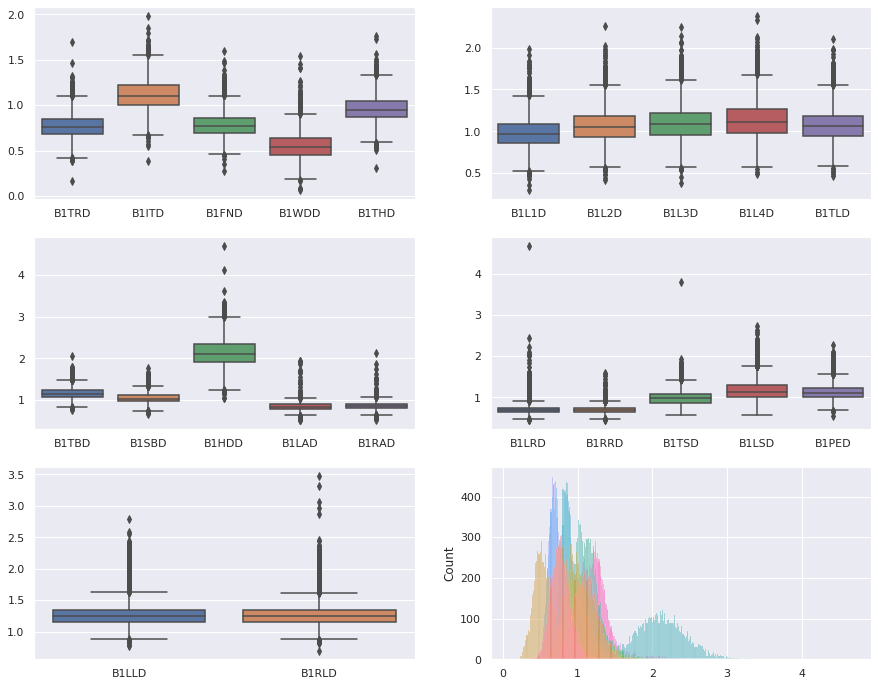

In [29]:
sns.set(rc={'figure.figsize':(15,12)})
fig, axs = plt.subplots(ncols=2,nrows=3)
sns.boxplot(data=baselineBMD.iloc[:,0:5],ax=axs[0,0])
sns.boxplot(data=baselineBMD.iloc[:,5:10],ax=axs[0,1])
sns.boxplot(data=baselineBMD.iloc[:,10:15],ax=axs[1,0])
sns.boxplot(data=baselineBMD.iloc[:,15:20],ax=axs[1,1])
sns.boxplot(data=baselineBMD.iloc[:,20:],ax=axs[2,0])
sns.histplot(data=baselineBMD,ax=axs[2,1],legend=False)

Interesting observation from the boxplot and histogram, The bone mineral density of the head is much greater than the others.

In [30]:
sns.reset_defaults()

### <a name="eda_VIF"></a> Multicollinearity Review
The multicollinearity review will use VIF to determine how correlated the Bone Mineral Densities are with each other.

In [31]:
vif_data = pd.DataFrame()
vif_data["feature"] = baselineBMD.columns
vif_data["VIF"] = [variance_inflation_factor(baselineBMD.values,i)\
 for i in range(len(baselineBMD.columns))]

In [32]:
vif_data

,feature,VIF
0,B1TRD,662.448695
1,B1ITD,2767.018356
2,B1FND,334.967851
3,B1WDD,59.789042
4,B1THD,7341.634157
5,B1L1D,1813.183626
6,B1L2D,2402.562430
7,B1L3D,2855.082215
8,B1L4D,3498.077731
9,B1TLD,37851.781208


We can see that all of the BMD values are highly correlated with eachother, indicating high multicollinearity. Depending on the model used we may want to create a BMD index with an average or even PCA. An additional strategy would be to consider dimension reduction techniques. Those two techniques follow.

### <a name="eda_PCA"></a> Principal Component Review
From initial review, we were able to confirm what we've read from the literature - the majority of the variance can be explained with the first principle component.  

Minimal clustering was found when exploring the top three principle components.

In [33]:
pca = PCA(n_components=3)
baselineBMD_scaled = StandardScaler().fit_transform(baselineBMD)
pca.fit(baselineBMD_scaled)
pcaBMD = pca.transform(baselineBMD_scaled)

In [34]:
pca.components_

array([[ 0.22498528,  0.21932525,  0.21711538,  0.20287125,  0.23377668,
         0.22371341,  0.2268152 ,  0.22599156,  0.21557221,  0.23758096,
         0.24969843,  0.2501126 ,  0.15431264,  0.19029923,  0.2081124 ,
         0.14548745,  0.19943205,  0.21342148,  0.22395632,  0.23102122,
         0.18171601,  0.17768118],
       [-0.15658769, -0.222669  , -0.19673712, -0.20082922, -0.21272279,
         0.26691114,  0.31707067,  0.33269542,  0.32289136,  0.33291991,
        -0.11347542, -0.14578513,  0.00943819, -0.18737468, -0.17829819,
        -0.02407137, -0.0343904 ,  0.10165607,  0.32356051, -0.05674235,
        -0.18557368, -0.22020558],
       [-0.27586764, -0.29844934, -0.34458482, -0.34335323, -0.3105127 ,
        -0.04585151, -0.03171897, -0.02167829, -0.02168791, -0.0312011 ,
         0.28649852,  0.26700989,  0.17720148,  0.14535105,  0.09661365,
         0.13694119,  0.13396936,  0.05769357, -0.03586356, -0.04092044,
         0.34872228,  0.34193592]])

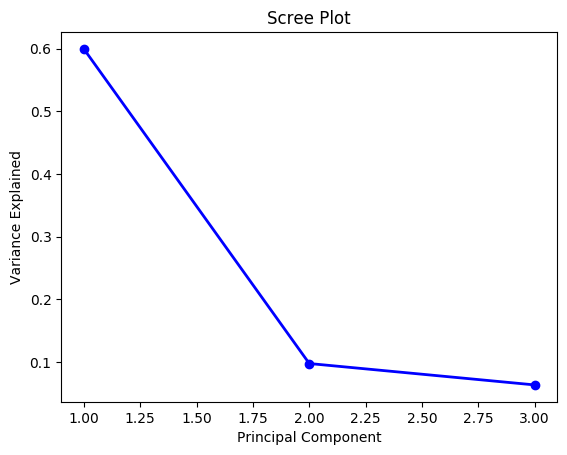

In [35]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Most of the variance is in the first principal component with extreme diminishing returns.This corresponds to the known literature.

In [36]:
pcaBMD_df = pd.DataFrame(pcaBMD,columns=["Component 1","Component 2","Component 3"])

In [37]:
pcaBMD_df = pd.concat([pcaBMD_df,y],axis=1)

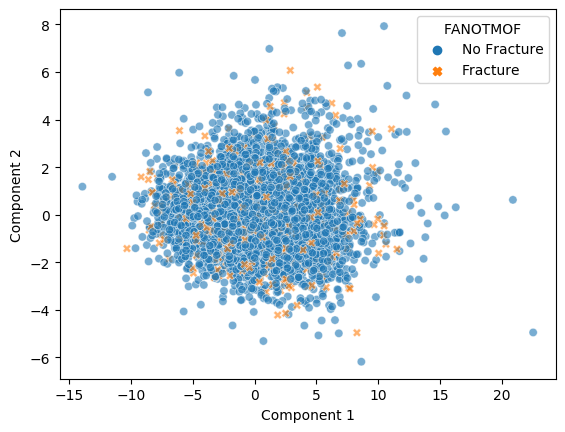

In [38]:
sns.scatterplot(data=pcaBMD_df, x="Component 1",y="Component 2",hue="FANOTMOF",style="FANOTMOF",alpha=0.6)
plt.show()

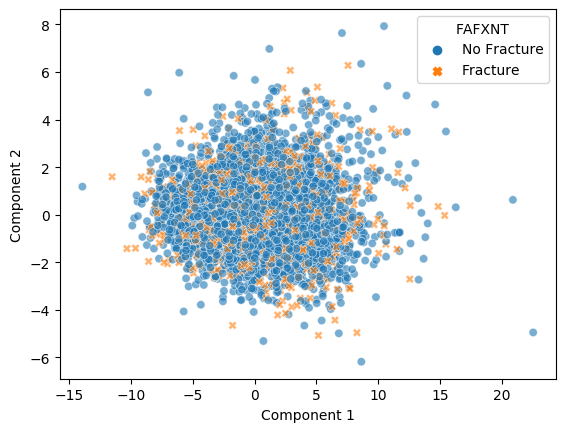

In [39]:
sns.scatterplot(data=pcaBMD_df, x="Component 1",y="Component 2",hue="FAFXNT",style="FAFXNT",alpha=0.6)
plt.show()

Let's get a better view by plotting Fractures on top of Non-fractures

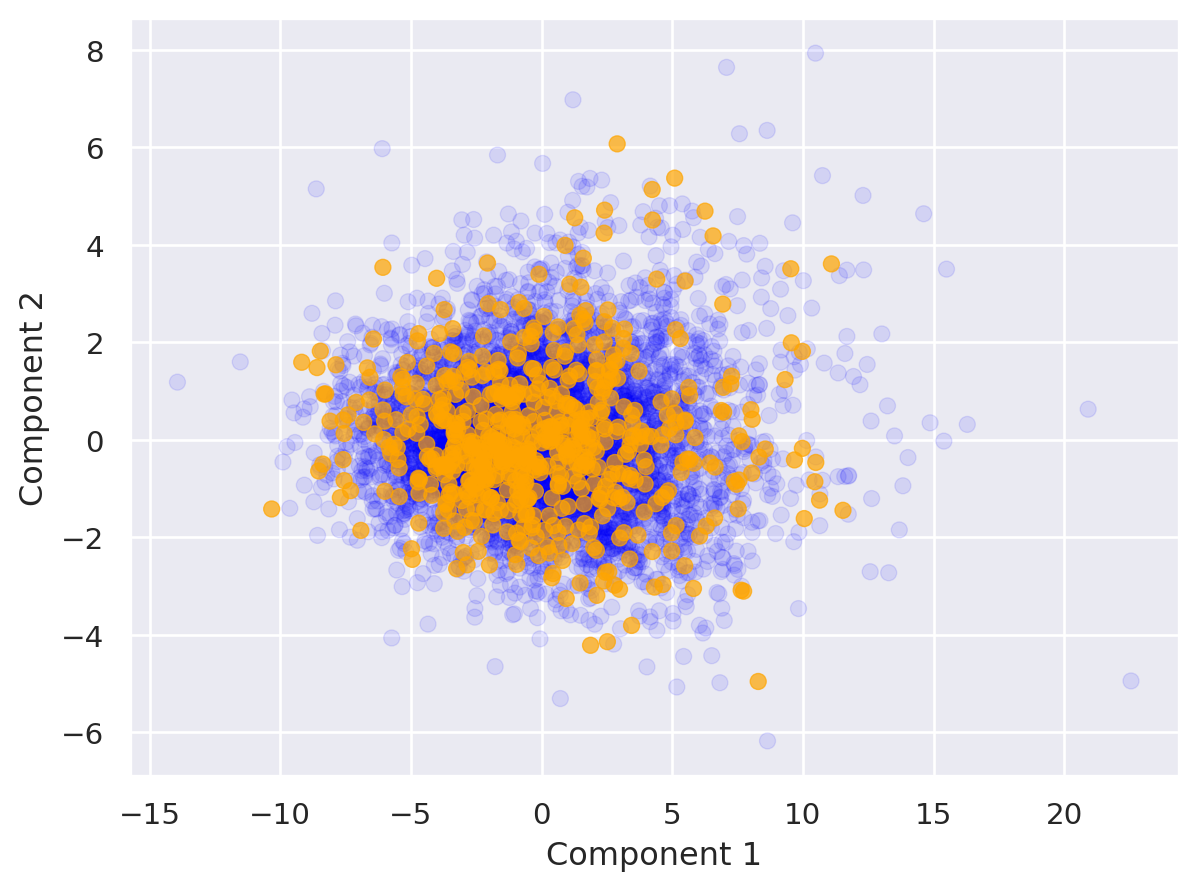

In [40]:
so.Plot(pcaBMD_df,x="Component 1",y="Component 2")\
.add(so.Dot(color="blue",alpha=0.1),data=pcaBMD_df[pcaBMD_df.FANOTMOF == "No Fracture"])\
.add(so.Dot(color="orange",alpha=0.7),data=pcaBMD_df[pcaBMD_df.FANOTMOF == "Fracture"])

The plot of the first two principal components doesn't show much evidence of clustering. However, we can see in the first principal component that scores under zero have a larger portion of the fractures.

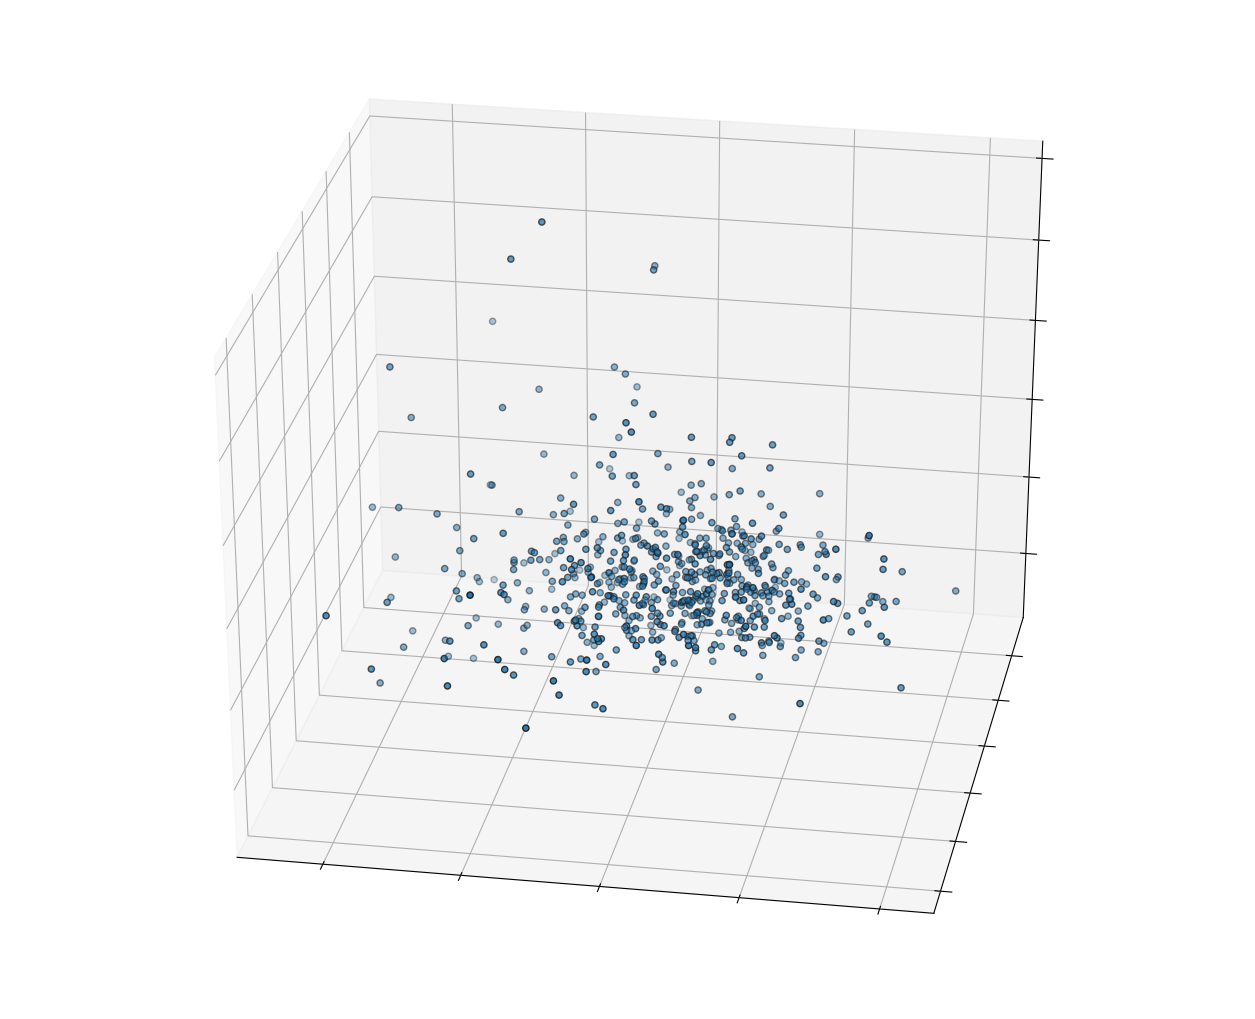

In [41]:
fig = plt.figure(1, figsize=(13,10))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=30, azim=100)
ax.set_position([0, 0, 0.95, 1])


plt.cla()

ax.scatter(pcaBMD_df[pcaBMD_df["FANOTMOF"]=="Fracture"]["Component 1"], pcaBMD_df[pcaBMD_df["FANOTMOF"]=="Fracture"]["Component 2"], pcaBMD_df[pcaBMD_df["FANOTMOF"]=="Fracture"]["Component 3"], edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

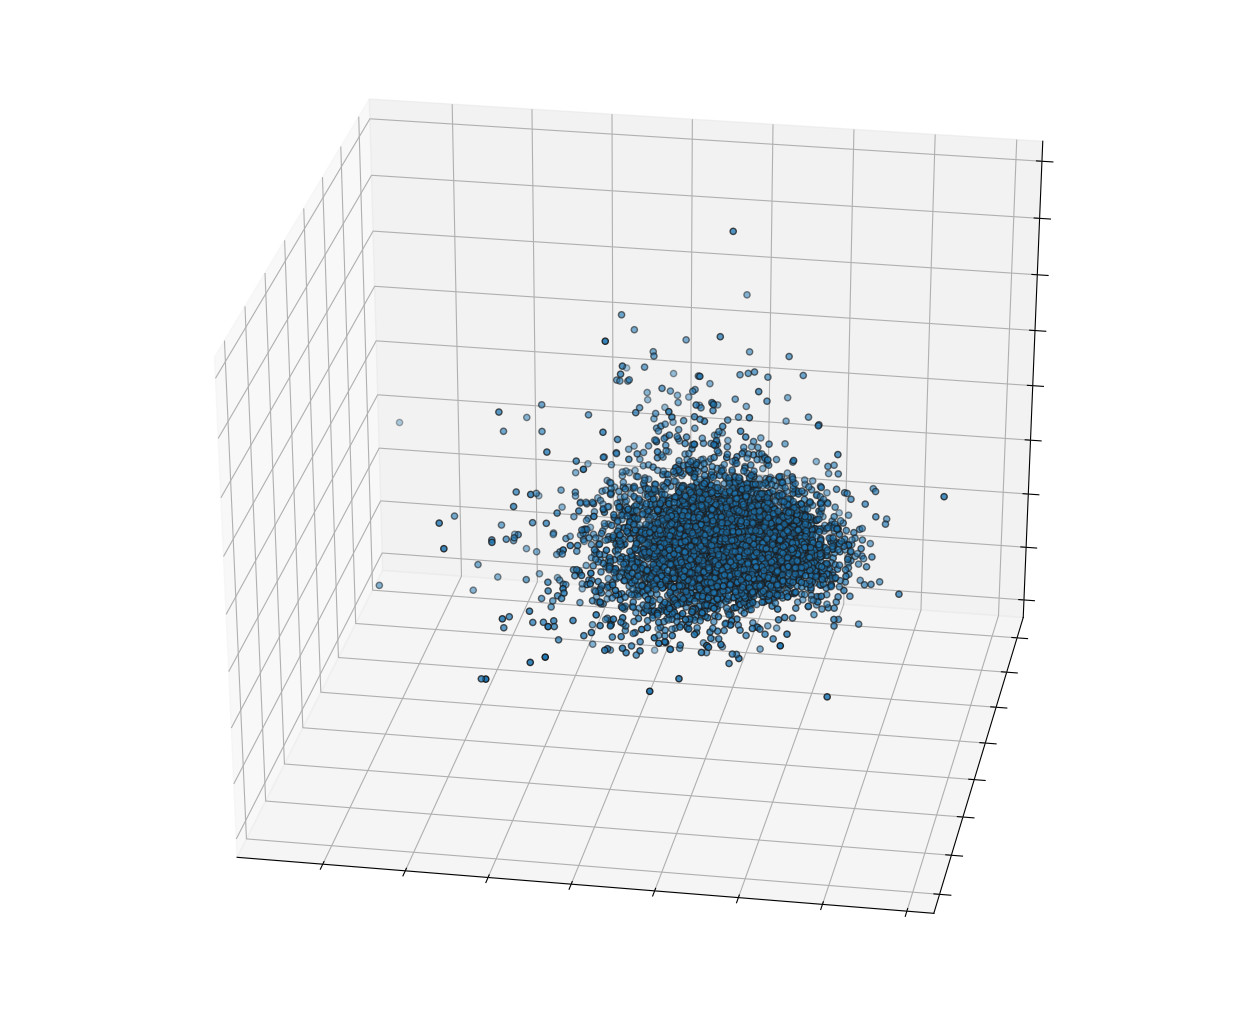

In [42]:
fig = plt.figure(1, figsize=(13,10))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=30, azim=100)
ax.set_position([0, 0, 0.95, 1])


plt.cla()

ax.scatter(pcaBMD_df[pcaBMD_df["FANOTMOF"]=="No Fracture"]["Component 1"], pcaBMD_df[pcaBMD_df["FANOTMOF"]=="No Fracture"]["Component 2"], pcaBMD_df[pcaBMD_df["FANOTMOF"]=="No Fracture"]["Component 3"], edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

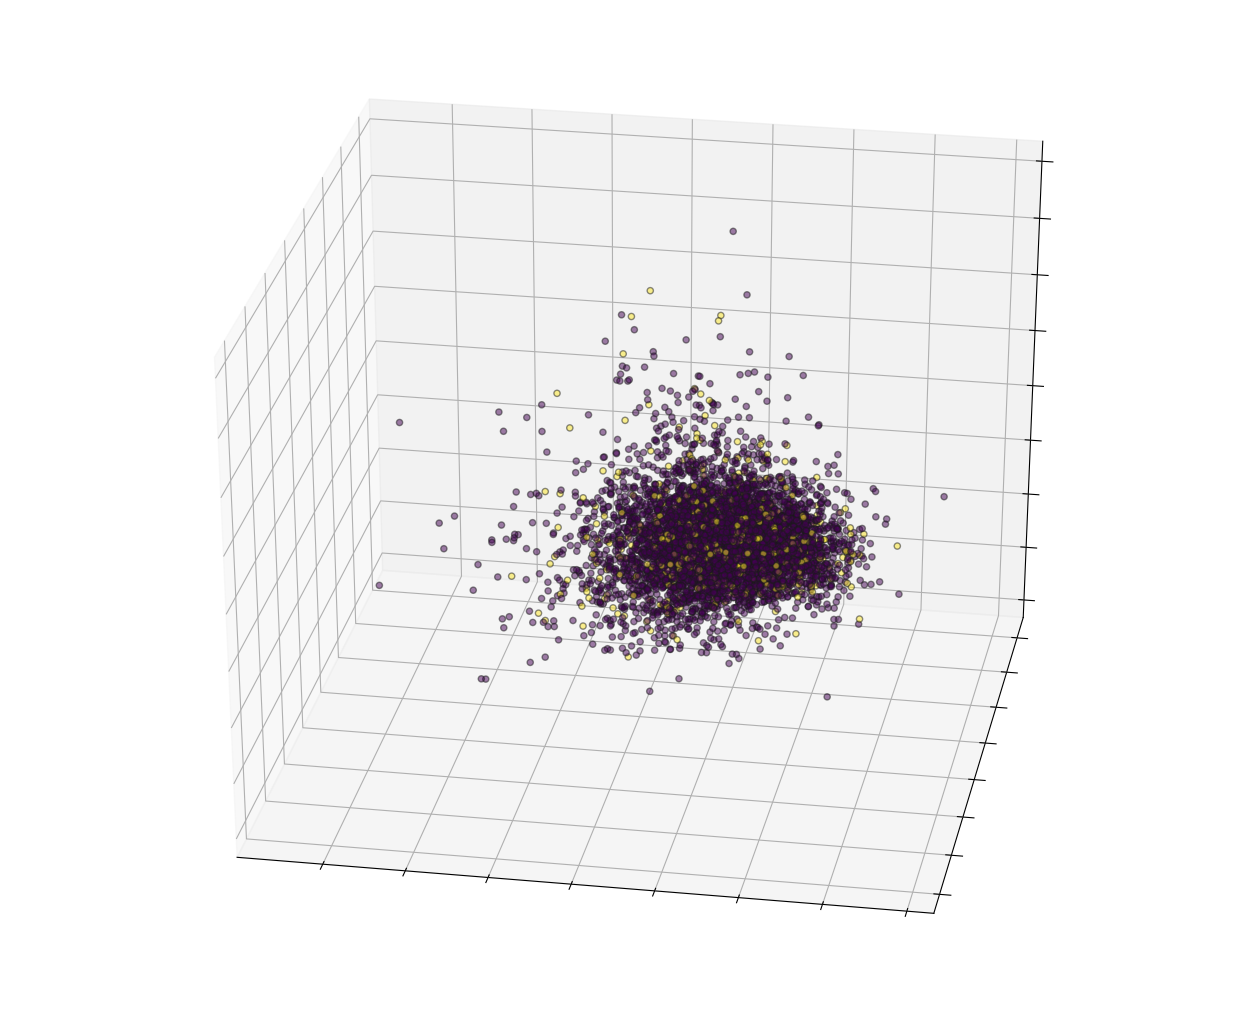

In [43]:
fig = plt.figure(1, figsize=(13,10))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=30, azim=100)
ax.set_position([0, 0, 0.95, 1])


plt.cla()

ax.scatter(pcaBMD_df["Component 1"], pcaBMD_df["Component 2"], pcaBMD_df["Component 3"], c=pcaBMD_df["FANOTMOF"].map({"Fracture":1,"No Fracture":0}), edgecolor="k", alpha = 0.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

There is not a clear distinction even amongst three principal components

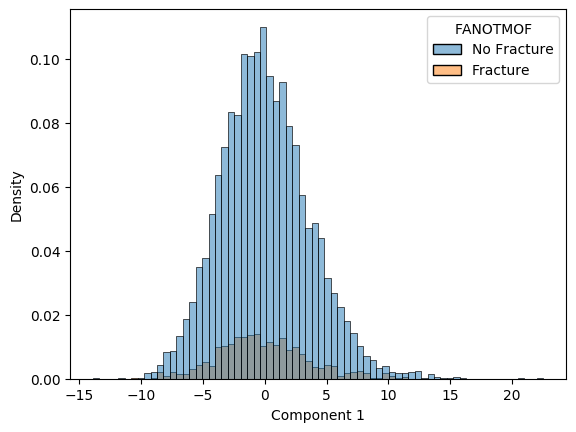

In [44]:
sns.histplot(data=pcaBMD_df, x="Component 1", hue="FANOTMOF",stat="density")

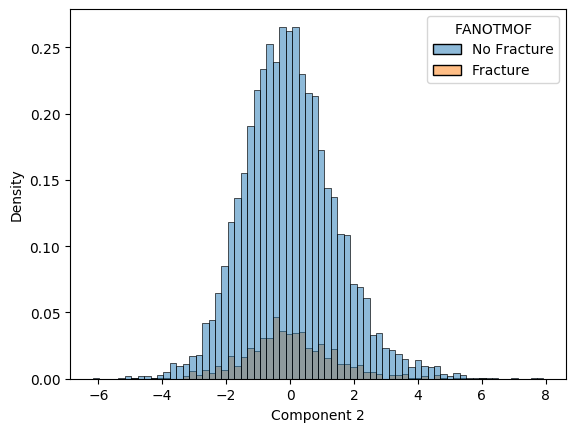

In [45]:
sns.histplot(data=pcaBMD_df, x="Component 2", hue="FANOTMOF",stat="density")

In [46]:
pcaBMD_df.groupby("FANOTMOF").aggregate(["mean","max","min"]).T

FANOTMOF           Fracture  No Fracture
Component 1 mean  -0.120137     0.018044
            max   11.531453    22.551425
            min  -10.326550   -13.932405
Component 2 mean   0.002668     0.002849
            max    6.067764     7.927563
            min   -4.959186    -6.178800
Component 3 mean   0.038455    -0.002456
            max    7.645051     9.590604
            min   -2.929039    -5.565571

In [47]:
pcaBMD_df.groupby("FAFXNT").aggregate(["mean","max","min"]).T

FAFXNT             Fracture  No Fracture
Component 1 mean  -0.037652     0.013539
            max   15.391686    22.551425
            min  -11.528354   -13.932405
Component 2 mean   0.010732     0.000658
            max    6.275670     7.927563
            min   -5.072322    -6.178800
Component 3 mean   0.061906    -0.014269
            max    7.645051     9.590604
            min   -2.962966    -5.565571

Descriptive statistics show that there is a slight difference between populations using the Principal Component Method

### <a name="eda_FS"></a>Using Feature Selection

The analysis below shows that there is a clear distinction between the "fracture" and "no fracture" population.  This also confirms what we had read during our literature review. 

In [48]:
##Top five based on f classifier

In [49]:
TopFeatures = SelectKBest(f_classif, k=5).fit(baselineBMD,y.FANOTMOF).get_support(indices=True)

In [50]:
TopBaseline = baselineBMD.iloc[:,TopFeatures]

In [51]:
TopMerged = pd.concat([TopBaseline,y.FANOTMOF],axis=1)

0.7014110656643947

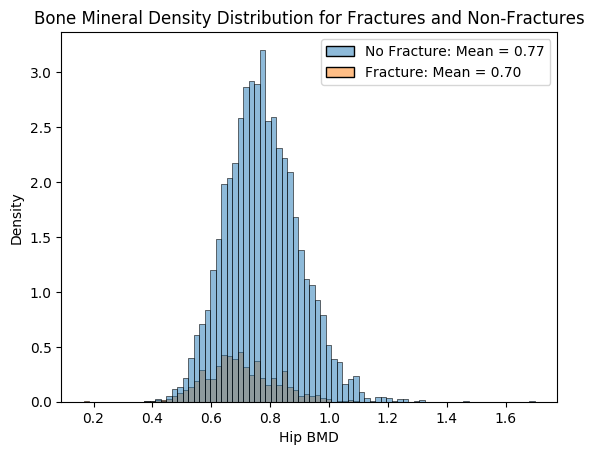

In [60]:
fig, ax1 = plt.subplots()
sp1 = sns.histplot( x=TopBaseline.iloc[:,0], hue=y.FANOTMOF,stat="density")
ax1.set_title("Bone Mineral Density Distribution for Fractures and Non-Fractures")
ax1.set_xlabel("Hip BMD")
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
meanfracture = np.mean(TopMerged[TopMerged.FANOTMOF == "Fracture"].iloc[:,0])
meannofracture = np.mean(TopMerged[TopMerged.FANOTMOF == "No Fracture"].iloc[:,0])
ax1.legend(handles, [ \
                      f"No Fracture: Mean = {meannofracture:.2f}",\
                     f"Fracture: Mean = {meanfracture:.2f}",\
                    ])

plt.show()

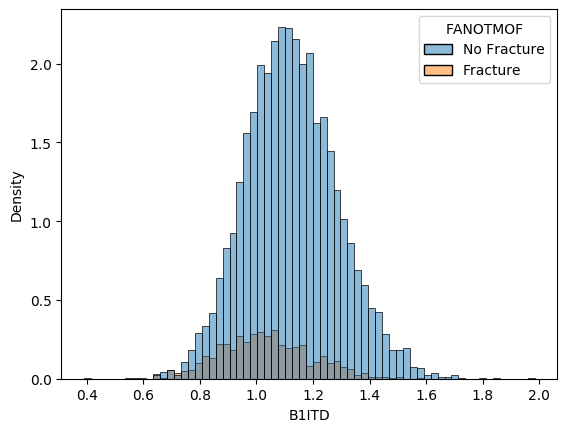

In [99]:
sns.histplot( x=TopBaseline.iloc[:,1], hue=y.FANOTMOF,stat="density")

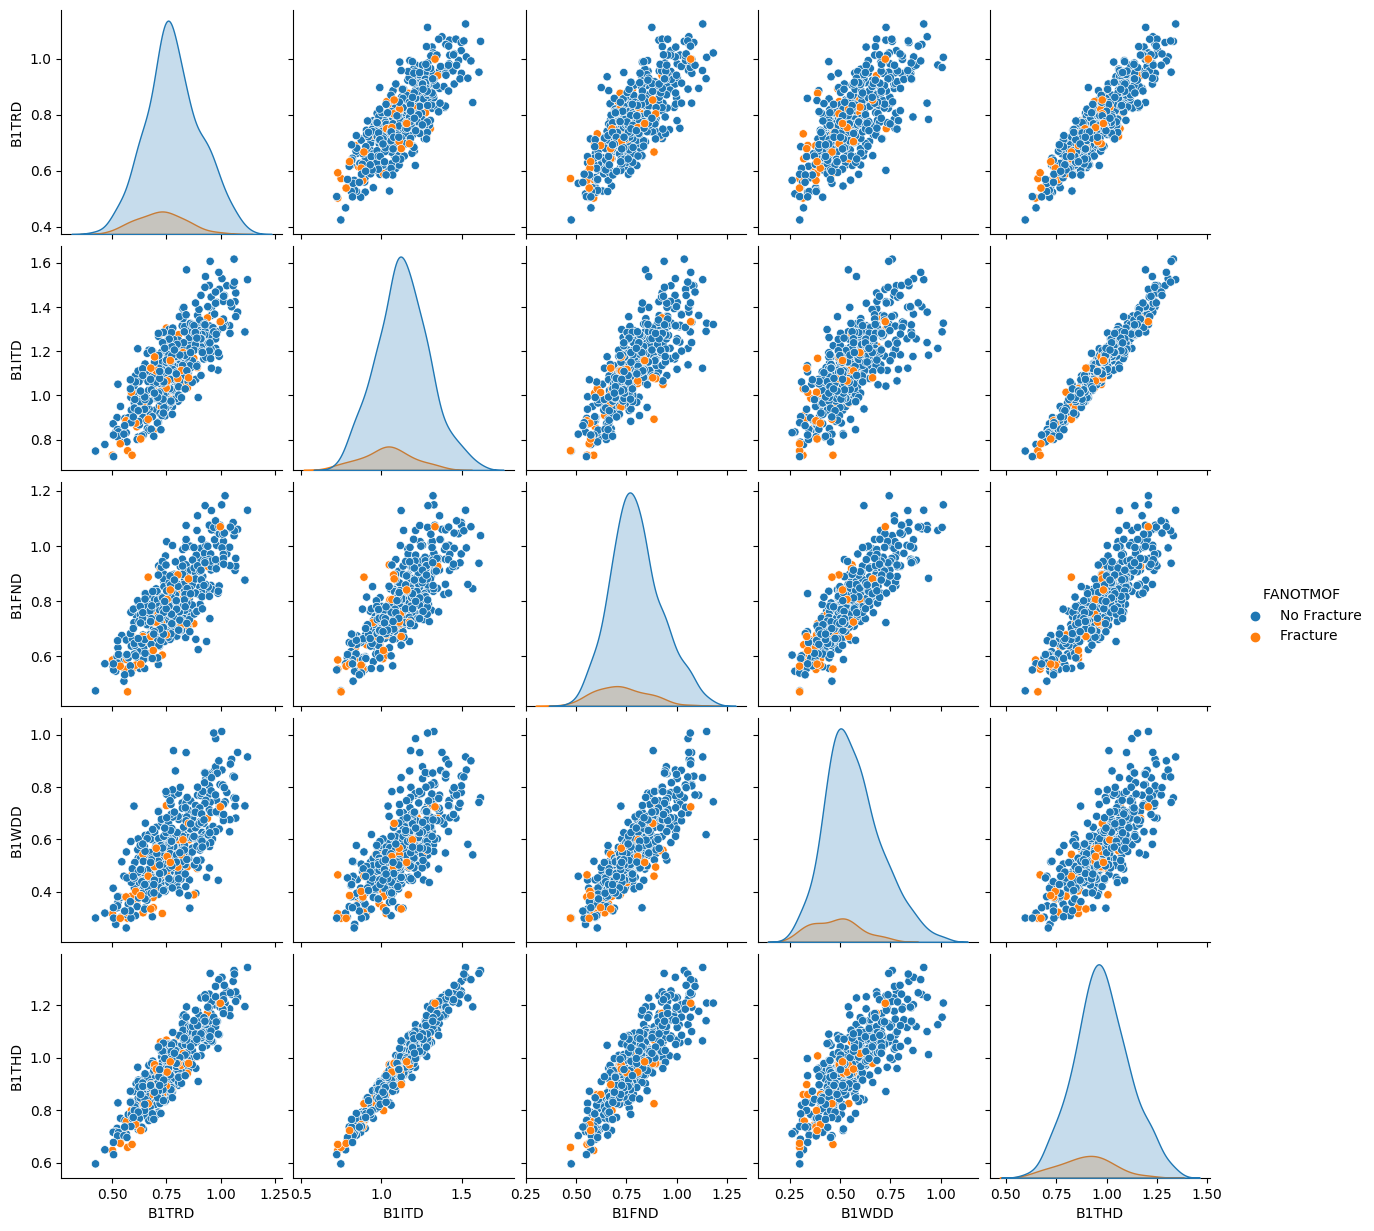

In [100]:
sns.pairplot(data=TopMerged.sample(500),hue="FANOTMOF")

In [101]:
TopMerged.groupby("FANOTMOF").aggregate(["mean","max","min"]).T

FANOTMOF    Fracture  No Fracture
B1TRD mean  0.701411     0.774156
      max   1.093780     1.699030
      min   0.167047     0.385267
B1ITD mean  1.028723     1.123845
      max   1.580770     1.984450
      min   0.389357     0.554777
B1FND mean  0.719157     0.793735
      max   1.271720     1.598350
      min   0.272729     0.403934
B1WDD mean  0.478935     0.560488
      max   1.092780     1.541770
      min   0.065489     0.084152
B1THD mean  0.883124     0.968374
      max   1.302000     1.763900
      min   0.306135     0.509475

From the above analysis, we can see a clear distinction between the two populations as BMD relates to incidence of fracture.

### <a name="eda_FR"></a>Results for Modeling

The following is cleaned data that will be used in further modelling.

In [102]:
results = baselineBMD_final.filter(regex="(?<!I)D$|^(ID)")

In [103]:
results.to_csv("/dsa/groups/casestudy2023su/team03/model_data/BMD_results.csv",index=False)
os.chmod("/dsa/groups/casestudy2023su/team03/model_data/BMD_results.csv",0o777)

file_path_with_nulls = "/dsa/groups/casestudy2023su/team03/model_data/null_included/BMD_results_with_nulls.csv"
bmd_with_nulls.to_csv(file_path_with_nulls, index=False)
##os.chmod(file_path_with_nulls, 0o777)